In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /Users/benjaminlaubach/Documents/GitHub/chimes_CGD-myLLFork/dissimilarity_clustering


In [3]:
# Get the current working directory
cwd = os.getcwd()

# Define file paths with cwd appended
file_path_2b = os.path.join(cwd, "dft_pds/2b_all_pd")
file_path_3b = os.path.join(cwd, "dft_pds/3b_all_pd")
file_path_4b = os.path.join(cwd, "dft_pds/4b_all_pd")
file_path_labels = os.path.join(cwd, "dft_pds/labels_pd")
file_path_natoms = os.path.join(cwd, "test_notebooks/energies_per_atom.txt")

# Open pickle files with the updated file paths
with open(file_path_2b, 'rb') as pickle_file:
    pd_2b = pickle.load(pickle_file)

with open(file_path_3b, 'rb') as pickle_file:
    pd_3b = pickle.load(pickle_file)

with open(file_path_4b, 'rb') as pickle_file:
    pd_4b = pickle.load(pickle_file)

with open(file_path_labels, 'rb') as pickle_file:
    labels = pickle.load(pickle_file)

natom_list = []

# Open the text file for reading
with open(file_path_natoms, 'r') as file:

    # Read the contents of the file
    lines = file.readlines()[1:]

    # Iterate through each line
    for line in lines:

        # Split the line into words
        words = line.split()
        natoms = line.split("|")[1].strip()

        # Extract the last word, assuming it's a number
        last_number = float(words[-1])
        if words[0][-1] == 'z':
            print(words[0])
            continue
        natom_list.append(natoms)

natom_list = np.array(natom_list[:-10])

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((pd_2b, pd_3b, pd_4b), axis=2)
all_array = all_array.reshape(-1, all_array.shape[2])
print(np.shape(all_array))
df_fingerprints = pd.DataFrame(all_array)

# Define the column labels for each set of columns
column_labels_2b = [f'2B_{i}' for i in range(60)]
column_labels_3b = [f'3B_{i}' for i in range(60)]
column_labels_4b = [f'4B_{i}' for i in range(60)]

# Assign the column labels to the DataFrame
column_labels = column_labels_2b + column_labels_3b + column_labels_4b
df_fingerprints.columns = column_labels

# Add a new column "labels" to the DataFrame and assign the new vector to it
df_fingerprints['labels'] = labels

# Calculate the row-wise mean using `mean(axis=1)`
row_avg = df_fingerprints.mean(axis=1)

# Append the calculated row-wise mean as a new column named "Pavg"
df_fingerprints['Pavg'] = row_avg

# Calculate the row-wise standard deviation using `std(axis=1)`
row_std = df_fingerprints.std(axis=1)

# Append the calculated row-wise standard deviation as a new column named "Pstd"
df_fingerprints['Pstd'] = row_std

# Append Natoms to Dataframe
df_fingerprints['Natoms'] = natom_list

df_fingerprints.head()


training_data_#0000.xyz
training_data_#0050.xyz
training_data_#0055.xyz
training_data_#0060.xyz
training_data_#0075.xyz
training_data_#0080.xyz
training_data_#0110.xyz
(300, 180)


,2B_0,2B_1,2B_2,2B_3,2B_4,2B_5,2B_6,2B_7,2B_8,2B_9,...,4B_54,4B_55,4B_56,4B_57,4B_58,4B_59,labels,Pavg,Pstd,Natoms
0,0.151940,0.079974,0.039987,0.134957,0.000000,0.039987,0.000000,0.059981,0.000000,0.064979,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016335,0.025764,216
1,0.151838,0.089548,0.030670,0.107863,0.026939,0.039628,0.000530,0.059527,0.008709,0.053400,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016335,0.024411,216
2,0.152059,0.091794,0.027968,0.104630,0.029103,0.039305,0.001128,0.058054,0.005966,0.057973,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016335,0.024316,216
3,0.113888,0.093885,0.074372,0.063481,0.048075,0.037675,0.033869,0.031662,0.025958,0.021373,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016348,0.020050,216
4,0.118745,0.094125,0.073008,0.061039,0.048168,0.036493,0.032401,0.030655,0.026413,0.021867,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.016344,0.020228,216


In [4]:
# Initialize the minimum occurrence count required
def compute_pij(phi1, phi2):

    # Compute statistics for training set
    phi1_fingerprint = phi1.iloc[:-4]
    avg_phi1 = phi1.iloc[-3]
    std_phi1 = phi1.iloc[-2]
    natoms_phi1 = float(phi1.iloc[-1])

    # Compute statistics for phi2
    phi2_fingerprint = phi2.iloc[:-4]
    avg_phi2 = phi2.iloc[-3]
    std_phi2 = phi2.iloc[-2]
    natoms_phi2 = float(phi2.iloc[-1])

    # Standardize Natoms
    natoms = np.sqrt(natoms_phi1*natoms_phi2)

    # Compute pij
    numerator = np.sum((phi1_fingerprint - avg_phi1)*(phi2_fingerprint - avg_phi2))
    denominator = natoms*std_phi1*std_phi2
    pij = numerator/denominator

    return pij

n = int(len(df_fingerprints))
pij_matrix = np.zeros((n,n))

# Iterate over each pair of rows
for i in range(n):
    for j in range(n):
        # Compute the scalar using compute_pij function
        pij = compute_pij(df_fingerprints.iloc[i], df_fingerprints.iloc[j])
        # Assign the scalar to the corresponding index in zeros_array
        pij_matrix[i, j] = pij

print(pij_matrix)

[[0.83610179 0.81729941 0.81652172 ... 0.01457645 0.01439321 0.01449416]
 [0.81729941 0.83588982 0.8350873  ... 0.01536529 0.01517977 0.01528734]
 [0.81652172 0.8350873  0.83587366 ... 0.01540713 0.01522133 0.01532995]
 ...
 [0.01457645 0.01536529 0.01540713 ... 0.00547451 0.00547592 0.00547502]
 [0.01439321 0.01517977 0.01522133 ... 0.00547592 0.00547899 0.00547697]
 [0.01449416 0.01528734 0.01532995 ... 0.00547502 0.00547697 0.00547584]]


In [5]:
# Create a new matrix to store the results
normal_pij = np.empty_like(pij_matrix, dtype=float)

# Step 1: Calculate the diagonal elements
diagonal_elements = np.diag(pij_matrix)

for idx, column in enumerate(pij_matrix.T):
    normal_pij[:, idx] = column / diagonal_elements[idx]

print(normal_pij)

[[1.         0.97775974 0.97684825 ... 2.66260218 2.62698068 2.64693055]
 [0.97751185 1.         0.99905923 ... 2.8066953  2.77053985 2.79178256]
 [0.97658171 0.99903993 1.         ... 2.81433828 2.77812537 2.7995635 ]
 ...
 [0.01743382 0.01838195 0.01843237 ... 1.         0.99943947 0.999851  ]
 [0.01721466 0.01816001 0.01821009 ... 1.00025758 1.         1.00020646]
 [0.0173354  0.01828871 0.01834003 ... 1.00009263 0.99962992 1.        ]]


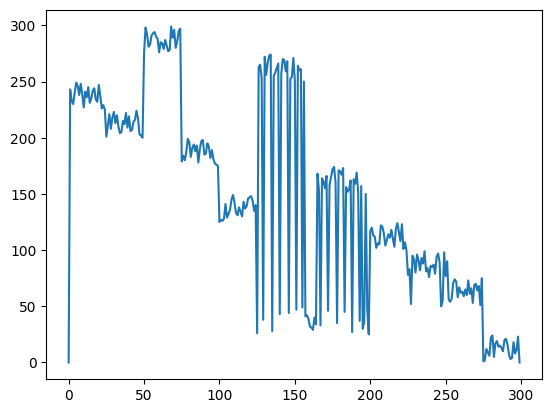

In [28]:
def calculate_min_pij(frame_pij_matrix):

    if frame_pij_matrix.ndim == 1:
        frame_pij_matrix = frame_pij_matrix.reshape(1, -1)  # Reshape into a single row
        min_index = np.argmin(first_column)
    else:

        # Sum each row
        row_sums = np.sum(frame_pij_matrix, axis=1)

        # Find the index of the row with the minimum sum
        min_index = np.argmin(row_sums)

    # Add row
    #print(min_index)

    return min_index

def update_datasets(training_frames, available_frames, pij_matrix_copy, training_pij, min_index):

    pij_matrix_copy[min_index, :] = np.inf
    column_n = pij_matrix_copy[:, min_index-1:min_index]
    training_pij = np.hstack((training_pij, column_n))

    row_to_append = available_frames.loc[min_index]
    training_frames = pd.concat([training_frames, row_to_append], axis=1, join="inner")

    return training_frames, available_frames, pij_matrix_copy, training_pij


starting_frame = 0
training_set = pd.DataFrame()
training_set = pd.concat([training_set, df_fingerprints.iloc[starting_frame]])
pij_matrix_copy = copy.copy(pij_matrix)

# Modify Pij matrix
pij_matrix_copy[starting_frame, :] = np.inf
training_pij_copy = copy.copy(pij_matrix_copy[:, :1])

# Extract the first column
first_column = pij_matrix_copy[:, starting_frame]
min_index = calculate_min_pij(first_column)

frame_list = [0]
for i in range(299):
    training_set, df_fingerprints, pij_matrix_copy, training_pij_copy = update_datasets(training_set, df_fingerprints, pij_matrix_copy, training_pij_copy, min_index)
    min_index = calculate_min_pij(training_pij_copy)
    frame_list.append(min_index)
plt.plot(frame_list)
